In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

In [2]:
merge = pd.read_csv("Latest_all_in_one.csv")
merge.head()

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,LeftEntorhinal,RightTemporalPole,LeftTemporalPole,RightParahippocampal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,647.947833,1078.037276,1457.480672,1512.146246,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,1007.538829,938.695742,1252.944187,1614.977833,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,618.004108,1094.889167,1245.740564,1440.387527,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,511.055653,1037.524095,1233.834362,1379.850263,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1795.531129,1881.167048,1235.603969,2169.129587,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152


In [3]:
sleep_cols = ['Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
merge['MHSleep'] = merge[sleep_cols].sum(axis=1)

In [4]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_vars = ['RightEntorhinal',
 'LeftEntorhinal',
 'RightTemporalPole',
 'LeftTemporalPole',
 'RightParahippocampal',
 'LeftParahippocampal',
 'RightInferiorTemporal',
 'LeftInferiorTemporal',
 'RightMiddleTemporal',
 'LeftMiddleTemporal',
 'RightFusiform',
 'LeftFusiform',
 'RightInferiorParietal',
 'LeftInferiorParietal',
 'RightIsthmusCingulate',
 'LeftIsthmusCingulate',
 'RightBankssts',
 'LeftBankssts',
 'RightPrecuneus',
 'LeftPrecuneus',
 'RightHippocampus',
 'LeftHippocampus',
 'RightAmygdala',
 'LeftAmygdala',
 'RightAccumbensArea',
 'LeftAccumbensArea',
 'RightMedialOrbitofrontal',
 'LeftMedialOrbitofrontal',
 'RightPallidum',
 'LeftPallidum',
 'RightCaudalMiddleFrontal',
 'LeftCaudalMiddleFrontal',
 'RightPutamen',
 'LeftPutamen',
 'RightRostralAnteriorCingulate',
 'LeftRostralAnteriorCingulate',
 'RightParacentral',
 'LeftParacentral',
 'RightPrecentral',
 'LeftPrecentral',
 'RightLingual',
 'LeftLingual',
 'LeftEntorhinal',
 'LeftHippocampus',
 'LeftFusiform',
 'LeftMiddleTemporal',
 'LeftParacentral',
 'RightInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'RightLateralVentricle',
 'LeftLateralVentricle',
 'LeftLateralVentricle']


In [5]:
merge_scale = merge.copy()

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [7]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes +
    mri_vars + ['BMI', 'Adjusted_Age']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [8]:
categorical_vars = ['DX', 'PTETHCAT']
merge_scaled = pd.get_dummies(merge_scale, columns=categorical_vars, drop_first=True)

In [9]:
feature_rename_map = {
    'DX_1[T.True]': 'Dx_AD',
    'DX_2[T.True]': 'Dx_MCI',
    'PTGENDER': 'Sex',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT': 'Race',
    'PTETHCAT_1[T.True]': 'Not Hisp/Latino',
    'PTETHCAT_2[T.True]': 'Hispanic/Latino',
    'PTETHCAT_3[T.True]': 'Other Eth',
    'MH' : 'Medical history'
}

In [10]:
mri_outcomes = mri_vars
cognitive_outcomes = cognitive_outcomes
predictorscog = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2','PTETHCAT_2','PTRACCAT','PTMARRY','MH']
predictorsmri = ['PTGENDER', 'Adjusted_Age', 'PTEDUCAT', 'APOE4', 'DX_1', 'DX_2', 'PTETHCAT_2','PTRACCAT','PTMARRY','MH']

In [11]:
merge_norm = merge_scaled[merge_scaled['VISCODE']==3]

In [12]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
import patsy


In [13]:
lasso_results_cognitive = []
lasso_results_mri = []
model_counter = 1


def store_all_predictors_lasso(model, outcome, sleep_var, predictors, feature_names, X, y):
    coefs = model.coef_
    r2 = r2_score(y, model.predict(X))

    records = []
    for coef, name in zip(coefs, feature_names):
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': name,
            'Coefficient': coef,
            'P-Value': None,  
            'R-Squared': r2
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorscog)}"
            y, X = patsy.dmatrices(formula, data=merge_norm, return_type='dataframe')

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y.values.ravel())
            records = store_all_predictors_lasso(
                lasso, outcome, sleep_var, predictorscog + [sleep_var], X.columns, X_scaled, y.values.ravel()
            )

            lasso_results_cognitive.extend(records)
            model_counter += 1

        except Exception as e:
            print(f"[LASSO Cognitive] Error for {outcome} with {sleep_var}: {e}")


for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictorsmri)}"
            y, X = patsy.dmatrices(formula, data=merge_norm, return_type='dataframe')

            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y.values.ravel())
            records = store_all_predictors_lasso(
                lasso, outcome, sleep_var, predictorsmri + [sleep_var], X.columns, X_scaled, y.values.ravel()
            )

            lasso_results_mri.extend(records)
            model_counter += 1

        except Exception as e:
            print(f"[LASSO MRI] Error for {outcome} with {sleep_var}: {e}")


In [14]:
lasso_results_cognitive_df = pd.DataFrame(lasso_results_cognitive)
lasso_results_mri_df = pd.DataFrame(lasso_results_mri)

In [15]:
lasso_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value,R-Squared
0,model_1,ADNI_MEM,NPIK,Intercept,0.000000,None,0.667710
1,model_1,ADNI_MEM,NPIK,DX_1[T.True],-1.000055,None,0.667710
2,model_1,ADNI_MEM,NPIK,DX_2[T.True],-0.424855,None,0.667710
3,model_1,ADNI_MEM,NPIK,PTETHCAT_2[T.True],0.000625,None,0.667710
4,model_1,ADNI_MEM,NPIK,NPIK,-0.021460,None,0.667710
...,...,...,...,...,...,...,...
175,model_15,ADNI_EF2,MHSleep,PTEDUCAT,0.117055,None,0.491232
176,model_15,ADNI_EF2,MHSleep,APOE4,-0.041523,None,0.491232
177,model_15,ADNI_EF2,MHSleep,PTRACCAT,-0.000000,None,0.491232
178,model_15,ADNI_EF2,MHSleep,PTMARRY,-0.002143,None,0.491232


In [16]:
flat_cog = lasso_results_cognitive_df[~lasso_results_cognitive_df['Feature'].isin(
    ['Intercept', 'Group Var'])]
flat_mri = lasso_results_mri_df[~lasso_results_mri_df['Feature'].isin(
    ['Intercept', 'Group Var'])]

In [17]:
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\Dark\AppData\Local\Temp\ipykernel_5280\57647515.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
C:\Users\Dark\AppData\Local\Temp\ipykernel_5280\57647515.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)


In [20]:
import math


def plot_lasso(df, domain='Cognitive', n_cols=2, coef_threshold=None):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var
        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )
        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )

        ax.axvline(x=0, color='red', linestyle='--', label='Zero')

        if coef_threshold is None:
            nonzero_coefs = df_plot['Coefficient'].abs()
            nonzero_coefs = nonzero_coefs[nonzero_coefs > 1e-4]
            if not nonzero_coefs.empty:
                threshold = 0.05
                ax.axvline(x=threshold, color='green', linestyle=':', label='Significant Threshold')
                ax.axvline(x=-threshold, color='green', linestyle=':')

        else:
            ax.axvline(x=coef_threshold, color='green', linestyle=':', label='Significant Threshold')
            ax.axvline(x=-coef_threshold, color='green', linestyle=':')

        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1], bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor', bbox_to_anchor=(1.02, 1.05), loc='upper left')

    fig.suptitle(f'Lasso Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()


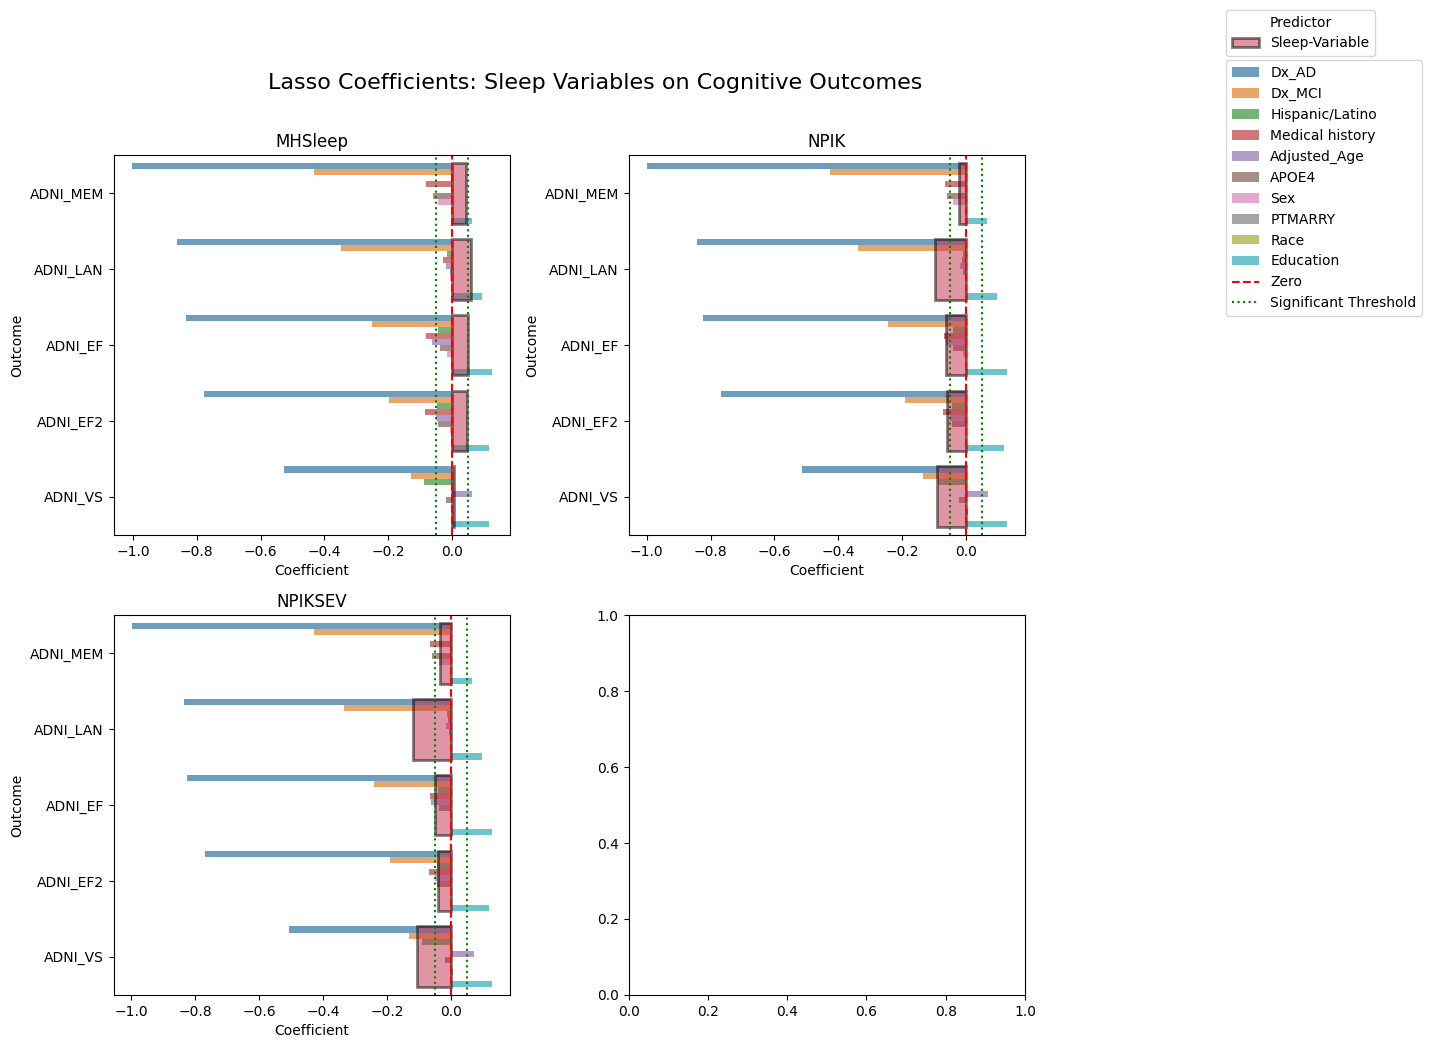

In [21]:
plot_lasso(flat_cog.sort_values(
    by='Coefficient'), domain='Cognitive')

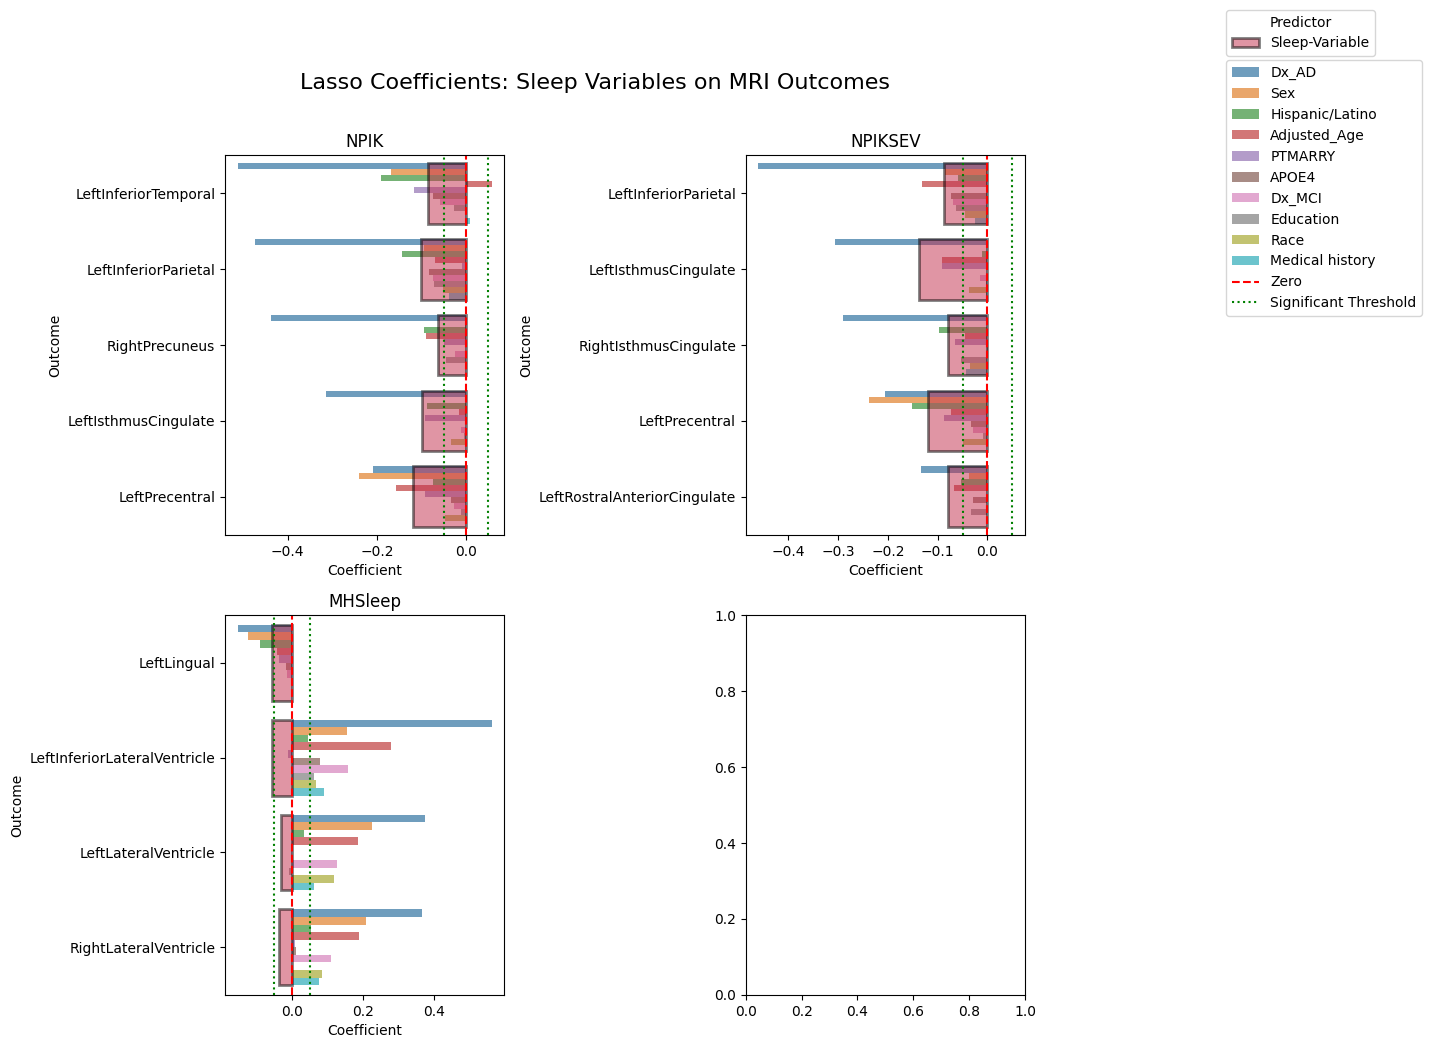

In [22]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[(flat_mri['Sleep_Variable'] == sleep_var)]

    top_outcomes = (
        df_plot[(df_plot['Feature'] == sleep_var) ]
        .sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(5)
        .index
    )
    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top.sort_values(by='Coefficient'))

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lasso(df_top_all, domain='MRI')

In [23]:
flat_cog.sort_values(by = "Coefficient", inplace=True)

C:\Users\Dark\AppData\Local\Temp\ipykernel_5280\3473619753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog.sort_values(by = "Coefficient", inplace=True)


In [24]:
summary_rows = []

for sleep_var in flat_cog['Sleep_Variable'].unique():
    for outcome in flat_cog['Outcome'].unique():
        subset = flat_cog[
            (flat_cog['Sleep_Variable'] == sleep_var) &
            (flat_cog['Outcome'] == outcome)
        ]

        if subset.empty:
            continue
        top_neg = subset.nsmallest(3, 'Coefficient')
        for _, row in top_neg.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Negative',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })
        top_pos = subset.nlargest(3, 'Coefficient')
        for _, row in top_pos.iterrows():
            summary_rows.append({
                'Sleep_Variable': sleep_var,
                'Outcome': outcome,
                'Direction': 'Most Positive',
                'Feature': row['Feature'],
                'Coefficient': row['Coefficient'],
                'P-Value': row['P-Value'],
                'R-Squared': row['R-Squared']
            })

cog_summary_df = pd.DataFrame(summary_rows)
cog_summary_df = cog_summary_df.sort_values(
    by=['Outcome', 'Sleep_Variable', 'Direction'])

In [25]:
cog_summary_df

,Sleep_Variable,Outcome,Direction,Feature,Coefficient,P-Value,R-Squared
12,MHSleep,ADNI_EF,Most Negative,Dx_AD,-0.835221,None,0.532783
13,MHSleep,ADNI_EF,Most Negative,Dx_MCI,-0.248932,None,0.532783
14,MHSleep,ADNI_EF,Most Negative,Medical history,-0.081998,None,0.532783
15,MHSleep,ADNI_EF,Most Positive,Education,0.126713,None,0.532783
16,MHSleep,ADNI_EF,Most Positive,MHSleep,0.051039,None,0.532783
...,...,...,...,...,...,...,...
85,NPIKSEV,ADNI_VS,Most Negative,Dx_MCI,-0.132329,None,0.271683
86,NPIKSEV,ADNI_VS,Most Negative,NPIKSEV,-0.106557,None,0.271683
87,NPIKSEV,ADNI_VS,Most Positive,Education,0.127448,None,0.271683
88,NPIKSEV,ADNI_VS,Most Positive,Adjusted_Age,0.071289,None,0.271683


In [26]:
def lasso_significance_testing(data, outcome, sleep_var, predictors, alpha=0.05):
    formula = f"{outcome} ~ {sleep_var} + {' + '.join(predictors)}"
    y, X = patsy.dmatrices(formula, data=data, return_type='dataframe')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y.values.ravel())

    selected_columns = X.columns[lasso.coef_ != 0]
    if len(selected_columns) == 0:
        print(f"No features selected for outcome: {outcome} with sleep var: {sleep_var}")
        return pd.DataFrame()

    X_selected = X[selected_columns]
    ols_model = sm.OLS(y, sm.add_constant(X_selected)).fit()

    results_df = pd.DataFrame({
        'Feature': ['Intercept'] + selected_columns.tolist(),
        'Coefficient': ols_model.params.values,
        'P-Value': ols_model.pvalues.values,
        'R-Squared': [ols_model.rsquared] * len(ols_model.params)
    })

    return results_df


In [27]:
cog_results = []
for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        df_res = lasso_significance_testing(
            data=merge_norm,
            outcome=outcome,
            sleep_var=sleep_var,
            predictors=predictorscog
        )
        df_res['Outcome'] = outcome
        df_res['Sleep_Variable'] = sleep_var
        cog_results.append(df_res)

mri_results = []
for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        df_res = lasso_significance_testing(
            data=merge_norm,
            outcome=outcome,
            sleep_var=sleep_var,
            predictors=predictorsmri
        )
        df_res['Outcome'] = outcome
        df_res['Sleep_Variable'] = sleep_var
        mri_results.append(df_res)

cognitive_significance_df = pd.concat(cog_results, ignore_index=True)
mri_significance_df = pd.concat(mri_results, ignore_index=True)


In [36]:
# --- Create Summary Table for MRI Outcomes with P-Value Significance --- #

# Get all unique sleep variables and MRI outcomes from lasso_results_mri
sleep_vars_unique = sorted(list(set([r['Sleep_Variable'] for r in lasso_results_mri])))
mri_outcomes_unique = sorted(list(set([r['Outcome'] for r in lasso_results_mri])))

# Initialize empty DataFrame
summary_table = pd.DataFrame(index=mri_outcomes_unique, columns=sleep_vars_unique)

# Fill in the table
for sleep_var in sleep_vars_unique:
    for outcome in mri_outcomes_unique:
        # Run significance testing to get updated coefficients and p-values
        result_df = lasso_significance_testing(
            data=merge_norm,
            outcome=outcome,
            sleep_var=sleep_var,
            predictors=predictorsmri
        )

        # Find the row corresponding to the current sleep_var
        if not result_df.empty and sleep_var in result_df['Feature'].values:
            row = result_df[result_df['Feature'] == sleep_var].iloc[0]
            coef = row['Coefficient']
            pval = row['P-Value']
            # Mark with asterisk if p < 0.05
            entry = f"{coef:.3f}{'*' if pval < 0.05 else ''}"
            summary_table.loc[outcome, sleep_var] = entry
        else:
            summary_table.loc[outcome, sleep_var] = '—'  # Not selected or not significant

summary_table = summary_table.fillna('—')
summary_table


,MHSleep,NPIK,NPIKSEV
LeftAccumbensArea,0.125,0.186,0.061
LeftAmygdala,0.240*,0.224*,0.114
LeftBankssts,0.131,-0.095,-0.054
LeftCaudalMiddleFrontal,0.107,—,-0.072
LeftEntorhinal,—,0.071,—
LeftFusiform,0.126,-0.179,-0.107
LeftHippocampus,0.136,0.055,-0.009
LeftInferiorLateralVentricle,-0.130,0.098,0.163*
LeftInferiorParietal,0.185,-0.280*,-0.148*
LeftInferiorTemporal,0.171,-0.248*,-0.134*


In [37]:
def count_significant(row):
    # Count number of entries with '*' in the row
    return sum(str(val).endswith('*') for val in row)

summary_table_sorted = summary_table.copy()
summary_table_sorted['Significant_Count'] = summary_table_sorted.apply(count_significant, axis=1)
summary_table_sorted = summary_table_sorted.sort_values(by='Significant_Count', ascending=False)
summary_table_sorted.drop(columns='Significant_Count', inplace=True)
summary_table_sorted


,MHSleep,NPIK,NPIKSEV
RightAmygdala,0.183*,0.288*,0.145*
LeftAmygdala,0.240*,0.224*,0.114
LeftInferiorParietal,0.185,-0.280*,-0.148*
LeftIsthmusCingulate,0.123,-0.311*,-0.236*
LeftPrecentral,0.165,-0.341*,-0.198*
LeftInferiorTemporal,0.171,-0.248*,-0.134*
RightInferiorLateralVentricle,-0.056,0.109,0.184*
LeftRostralAnteriorCingulate,—,-0.213,-0.154*
RightFusiform,0.278*,-0.132,-0.074
RightAccumbensArea,0.204*,0.054,-0.015


In [29]:
from scipy import stats
import statsmodels.api as sm

def run_anova_and_normality_from_lasso(lasso_df, domain_name="MRI"):
    results = []

    for (outcome, sleep_var), group in lasso_df.groupby(['Outcome', 'Sleep_Variable']):
        try:
            # Get the row where Feature == sleep_var (i.e., the effect of the sleep var itself)
            sleep_effect = group[group['Feature'] == sleep_var]
            if sleep_effect.empty:
                continue

            coef = sleep_effect['Coefficient'].values[0]
            r2 = sleep_effect['R-Squared'].values[0]

            # Since LASSO doesn't provide p-values, skip ANOVA test here
            # Instead we can still test for normality of coefficients across models
            stat, p_shapiro = stats.shapiro(group['Coefficient'])

            results.append({
                'Outcome': outcome,
                'Sleep_Variable': sleep_var,
                'Coefficient': coef,
                'R-Squared': r2,
                'Shapiro-Wilk p': p_shapiro,
                'Normality': 'Yes' if p_shapiro > 0.05 else 'No',
                'Domain': domain_name
            })
        except Exception as e:
            print(f"[{domain_name}] Error in {outcome} with {sleep_var}: {e}")

    return pd.DataFrame(results)

# Usage:
anova_lasso_mri = run_anova_and_normality_from_lasso(flat_mri, domain_name="MRI")
anova_lasso_cog = run_anova_and_normality_from_lasso(flat_cog, domain_name="Cognitive")



In [30]:
anova_lasso_mri[anova_lasso_mri['Normality'] == 'No'].sort_values(by='Shapiro-Wilk p', ascending=False).head(10)


,Outcome,Sleep_Variable,Coefficient,R-Squared,Shapiro-Wilk p,Normality,Domain
64,LeftRostralAnteriorCingulate,NPIK,-0.057196,0.057224,0.049807,No,MRI
71,RightAccumbensArea,NPIKSEV,-0.003164,0.128801,0.044829,No,MRI
103,RightLateralVentricle,NPIK,0.046037,0.219073,0.040409,No,MRI
39,LeftMedialOrbitofrontal,MHSleep,-0.000000,0.111938,0.039873,No,MRI
41,LeftMedialOrbitofrontal,NPIKSEV,-0.005019,0.111633,0.036189,No,MRI
9,LeftCaudalMiddleFrontal,MHSleep,0.023429,0.119154,0.035807,No,MRI
40,LeftMedialOrbitofrontal,NPIK,-0.000000,0.111000,0.030558,No,MRI
122,RightParahippocampal,NPIKSEV,-0.024493,0.236052,0.026516,No,MRI
47,LeftPallidum,NPIKSEV,-0.028080,0.073325,0.023500,No,MRI
27,LeftInferiorTemporal,MHSleep,0.062371,0.289694,0.015255,No,MRI


In [31]:
anova_lasso_cog

,Outcome,Sleep_Variable,Coefficient,R-Squared,Shapiro-Wilk p,Normality,Domain
0,ADNI_EF,MHSleep,0.051039,0.532783,0.000152,No,Cognitive
1,ADNI_EF,NPIK,-0.064132,0.533614,0.000091,No,Cognitive
2,ADNI_EF,NPIKSEV,-0.050685,0.531848,0.000076,No,Cognitive
3,ADNI_EF2,MHSleep,0.047437,0.491232,0.000104,No,Cognitive
4,ADNI_EF2,NPIK,-0.061102,0.491971,0.000063,No,Cognitive
5,ADNI_EF2,NPIKSEV,-0.040301,0.489831,0.000050,No,Cognitive
6,ADNI_LAN,MHSleep,0.061745,0.481479,0.000031,No,Cognitive
7,ADNI_LAN,NPIK,-0.098890,0.485463,0.000049,No,Cognitive
8,ADNI_LAN,NPIKSEV,-0.118259,0.488400,0.000063,No,Cognitive
9,ADNI_MEM,MHSleep,0.043982,0.669690,0.000039,No,Cognitive


In [32]:
flat_cog_self = cognitive_significance_df[cognitive_significance_df['Feature'] == cognitive_significance_df['Sleep_Variable']]

pivot_df = flat_cog_self.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)
for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""
final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [33]:
final_df 

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,ADNI_EF,-0.20 (p=0.03)*,-0.10 (p=0.08),0.16 (p=0.06)
1,ADNI_EF2,-0.21 (p=0.03)*,-0.09 (p=0.13),0.16 (p=0.07)
2,ADNI_LAN,-0.30 (p=0.00)*,-0.20 (p=0.00)*,0.19 (p=0.04)*
3,ADNI_MEM,-0.09 (p=0.26),-0.07 (p=0.14),0.14 (p=0.05)
4,ADNI_VS,-0.28 (p=0.02)*,-0.19 (p=0.01)*,0.07 (p=0.46)


In [34]:
pivot_df = mri_significance_df.pivot_table(
    index="Outcome",
    columns="Sleep_Variable",
    values=["Coefficient", "P-Value"],
    aggfunc="first"
)
pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
pivot_df.reset_index(inplace=True)

for sv in sleep_vars:
    coef_col = f"Coefficient_{sv}"
    pval_col = f"P-Value_{sv}"
    if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
        pivot_df[sv] = pivot_df.apply(
            lambda row: (
                f"{row[coef_col]:.2f} (p={row[pval_col]:.2f}){'*' if row[pval_col] < 0.05 else ''}"
                if pd.notnull(row[coef_col]) else ""
            ),
            axis=1
        )
    else:
        pivot_df[sv] = ""

final_df = pivot_df[["Outcome"] + sleep_vars]
final_df.index.name = "Cognitive Outcome"

In [34]:
final_df 

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftAccumbensArea,0.47 (p=0.18),0.47 (p=0.19),0.43 (p=0.22)
1,LeftAmygdala,0.98 (p=0.00)*,0.98 (p=0.00)*,0.95 (p=0.00)*
2,LeftBankssts,0.58 (p=0.03)*,0.57 (p=0.03)*,0.57 (p=0.03)*
3,LeftCaudalMiddleFrontal,1.29 (p=0.00)*,1.30 (p=0.00)*,1.29 (p=0.00)*
4,LeftEntorhinal,0.21 (p=0.37),0.22 (p=0.36),0.22 (p=0.35)
5,LeftFusiform,1.26 (p=0.00)*,1.26 (p=0.00)*,1.25 (p=0.00)*
6,LeftHippocampus,1.51 (p=0.00)*,1.51 (p=0.00)*,1.50 (p=0.00)*
7,LeftInferiorLateralVentricle,-1.51 (p=0.00)*,-1.51 (p=0.00)*,-1.50 (p=0.00)*
8,LeftInferiorParietal,1.51 (p=0.00)*,1.50 (p=0.00)*,1.49 (p=0.00)*


In [31]:
final_df_sorted = final_df.copy()
for col in final_df.columns[1:]:
    final_df_sorted[col] = final_df_sorted[col].sort_values(ignore_index=True)
final_df_sorted

,Outcome,NPIK,NPIKSEV,MHSleep
Cognitive Outcome,,,,
0,LeftEntorhinal,-1.23 (p=0.00)*,-1.23 (p=0.00)*,-1.21 (p=0.00)*
1,LeftFusiform,-1.31 (p=0.00)*,-1.30 (p=0.00)*,-1.29 (p=0.00)*
2,LeftHippocampus,-1.34 (p=0.00)*,-1.34 (p=0.00)*,-1.34 (p=0.00)*
3,LeftInferiorLateralVentricle,-1.51 (p=0.00)*,-1.51 (p=0.00)*,-1.50 (p=0.00)*
4,LeftLateralVentricle,0.07 (p=0.27),0.06 (p=0.32),0.04 (p=0.49)
5,LeftMiddleTemporal,0.21 (p=0.00)*,0.21 (p=0.00)*,0.21 (p=0.00)*
6,LeftParacentral,0.21 (p=0.37),0.22 (p=0.36),0.22 (p=0.35)
7,RightAccumbensArea,0.48 (p=0.18),0.48 (p=0.18),0.41 (p=0.00)*
8,RightAmygdala,0.56 (p=0.00)*,0.55 (p=0.00)*,0.48 (p=0.18)


In [32]:
def extract_coef(value):
    try:
        return float(value.split(" (")[0])
    except:
        return None


for col in ['NPIK', 'NPIKSEV', 'MHSleep']:
    final_df_sorted[f'{col}_coef'] = final_df_sorted[col].apply(extract_coef)

summary_rows = []
for col in ['NPIK', 'NPIKSEV', 'MHSleep']:
    top_pos = final_df_sorted.nlargest(3, f'{col}_coef')[['Outcome', col]]
    top_neg = final_df_sorted.nsmallest(3, f'{col}_coef')[['Outcome', col]]

    for i, row in top_neg.iterrows():
        summary_rows.append({'Column': col, 'Direction': 'Most Negative',
                            'Outcome': row['Outcome'], 'Value': row[col]})
    for i, row in top_pos.iterrows():
        summary_rows.append({'Column': col, 'Direction': 'Most Positive',
                            'Outcome': row['Outcome'], 'Value': row[col]})

summary_df = pd.DataFrame(summary_rows)

In [33]:
summary_df 

,Column,Direction,Outcome,Value
0,NPIK,Most Negative,LeftInferiorLateralVentricle,-1.51 (p=0.00)*
1,NPIK,Most Negative,LeftHippocampus,-1.34 (p=0.00)*
2,NPIK,Most Negative,LeftFusiform,-1.31 (p=0.00)*
3,NPIK,Most Positive,RightTemporalPole,1.51 (p=0.00)*
4,NPIK,Most Positive,RightRostralAnteriorCingulate,1.50 (p=0.00)*
5,NPIK,Most Positive,RightPutamen,1.49 (p=0.00)*
6,NPIKSEV,Most Negative,LeftInferiorLateralVentricle,-1.51 (p=0.00)*
7,NPIKSEV,Most Negative,LeftHippocampus,-1.34 (p=0.00)*
8,NPIKSEV,Most Negative,LeftFusiform,-1.30 (p=0.00)*
9,NPIKSEV,Most Positive,RightTemporalPole,1.51 (p=0.00)*
